<a href="https://colab.research.google.com/github/zsteve/wtf/blob/main/examples/amino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://models.life.ku.dk/sites/default/files/Amino_Acid_fluo.zip
!unzip Amino_Acid_fluo.zip
!pip install pot tensorly
!git clone https://github.com/zsteve/wtf

--2021-08-18 19:51:39--  http://models.life.ku.dk/sites/default/files/Amino_Acid_fluo.zip
Resolving models.life.ku.dk (models.life.ku.dk)... 130.226.12.4
Connecting to models.life.ku.dk (models.life.ku.dk)|130.226.12.4|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 232472 (227K) [application/zip]
Saving to: ‘Amino_Acid_fluo.zip.1’

Amino_Acid_fluo.zip 100%[===================>] 227.02K  --.-KB/s    in 0.1s    

2021-08-18 19:51:39 (1.92 MB/s) - ‘Amino_Acid_fluo.zip.1’ saved [232472/232472]

Archive:  Amino_Acid_fluo.zip
replace amino.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: amino.mat               
fatal: destination path 'wtf' already exists and is not an empty directory.


In [2]:
import scipy.io
mat = scipy.io.loadmat('amino.mat')

In [3]:
X = mat['X']

In [4]:
import matplotlib.pyplot as plt

In [5]:
X = mat['X'].reshape(-1, 61, 201)
# downsample
# X = X[:, ::2, ::2]
# X = X[:, 0:30,maybe it's  0:30]
X[X < 0] = 0

In [6]:
X.shape

(5, 61, 201)

In [7]:
import os
import sys
os.chdir("/content/wtf")
sys.path.insert(0, "src")
import wtf


In [8]:
import numpy as np
import copy
import tensorly as tl
from tensorly import tenalg, decomposition, cp_tensor
from tensorly.contrib.sparse import tensor as sptensor
import ot
import torch
import sklearn 
from sklearn import datasets
plt.style.use('classic')

tl.set_backend("pytorch")
torch.set_default_tensor_type(torch.DoubleTensor)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tl_dtype = tl.float64

X = tl.tensor(np.array([wtf.normalise(i) for i in X]), dtype = tl_dtype)


In [9]:
sizex, sizey = X.shape[1:]
xx, yy = np.meshgrid(range(sizey), range(sizex))
xx = xx/sizey
yy = yy/sizex
coords = np.vstack((xx.reshape(1, sizex*sizey), yy.reshape(1, sizex*sizey))).T

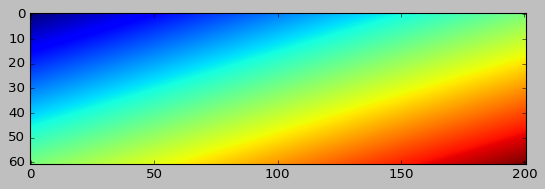

In [10]:
plt.imshow(coords.sum(-1).reshape(*X.shape[1:])) # plot to check that coords is correct

In [11]:
C_full = ot.utils.euclidean_distances(coords, coords, squared=True)
C_full = torch.Tensor(C_full/C_full.mean()).to(device)

In [12]:
d = 3
r = [3, ]*3
S = tl.zeros(r).to(device)
for i in range(r[0]):
    S[i, i, i] = 1

factor_cp = tl.decomposition.non_negative_parafac(X, rank = r[0], n_iter_max = 0, init = "random")
A = copy.deepcopy(factor_cp.factors)
A = [a.to(device) for a in A]
X0 = X.to(device)

n_iter = 5
lr = np.array([[1, 1, 1], ]*n_iter)*1
lamda = np.array([np.ones(3), ]*n_iter)*25
rho = np.array([np.array([1e-2, 1e-2, 1e-2]*3), ]*n_iter)
A[0] = (A[0].T/A[0].sum(1)).T
A[1] = A[1]/A[1].sum(0)
A[2] = A[2]/A[2].sum(0)

dual_objs = [[], [], [], ]
max_iter, print_inter, check_iter, unbal = (250, 10, 10, True) 
tol = 1e-3
mode = "lbfgs"
eps = [0.01, ]*3

In [13]:
for i in range(n_iter):
    print("Block iteration ", i)
    print("Mode 0")
    m0 = wtf.FactorsModel(X0, 0, [C_full, ], S, A, rho[i, :], eps, lamda[i, :], ot_mode = "slice", U_init = None, device = device, unbal = unbal, norm = "row")
    dual_objs[0] += [wtf.solve(m0, lr = lr[i, 0], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol), ]
    A[0] = m0.compute_primal_variable().detach()
    print("Mode 1") 
    m1 = wtf.FactorsModel(X0, 1, [C_full, ], S, A, rho[i, :], eps, lamda[i, :], ot_mode = "slice", U_init = None, device = device, unbal = unbal, norm = "col")
    dual_objs[1] += [wtf.solve(m1, lr = lr[i, 1], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol), ]
    A[1] = m1.compute_primal_variable().detach()
    print("Mode 2") 
    m2 = wtf.FactorsModel(X0, 2, [C_full, ], S, A, rho[i, :], eps, lamda[i, :], ot_mode = "slice", U_init = None, device = device, unbal = unbal, norm = "col")
    dual_objs[2] += [wtf.solve(m2, lr = lr[i, 2], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol), ]
    A[2] = m2.compute_primal_variable().detach()


Block iteration  0
Mode 0
i = 0 	 dual = 0.386789
i = 10 	 dual = -0.122019
i = 20 	 dual = -0.133397
Mode 1
i = 0 	 dual = 0.506795
i = 10 	 dual = 0.137049
i = 20 	 dual = 0.126808
Mode 2
i = 0 	 dual = 0.834628
i = 10 	 dual = 0.810497
Block iteration  1
Mode 0
i = 0 	 dual = 0.746273
i = 10 	 dual = 0.743803
Mode 1
i = 0 	 dual = 0.825913
i = 10 	 dual = 0.819319
Mode 2
i = 0 	 dual = 0.847419
i = 10 	 dual = 0.840658
Block iteration  2
Mode 0
i = 0 	 dual = 0.744782
i = 10 	 dual = 0.742434
Mode 1
i = 0 	 dual = 0.827735
i = 10 	 dual = 0.824940
Mode 2
i = 0 	 dual = 0.850904
i = 10 	 dual = 0.847913
Block iteration  3
Mode 0
i = 0 	 dual = 0.746903
i = 10 	 dual = 0.745041
Mode 1
i = 0 	 dual = 0.828761
i = 10 	 dual = 0.825957
Mode 2
i = 0 	 dual = 0.851077
i = 10 	 dual = 0.848028
Block iteration  4
Mode 0
i = 0 	 dual = 0.746585
i = 10 	 dual = 0.744678
Mode 1
i = 0 	 dual = 0.828831
i = 10 	 dual = 0.826271
Mode 2
i = 0 	 dual = 0.851452
i = 10 	 dual = 0.848714


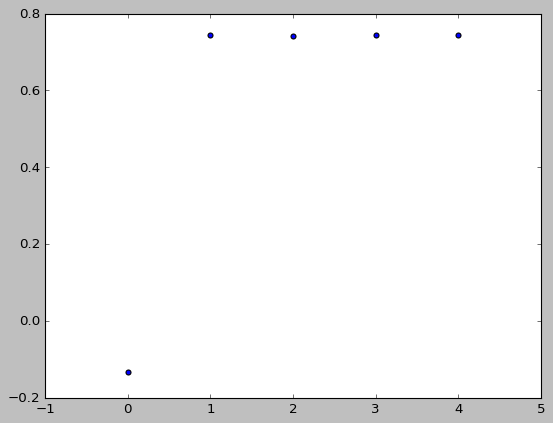

In [14]:
plt.scatter(np.arange(n_iter), dual_objs[0])

Text(0.5, 0.98, 'Frobenius-CP')

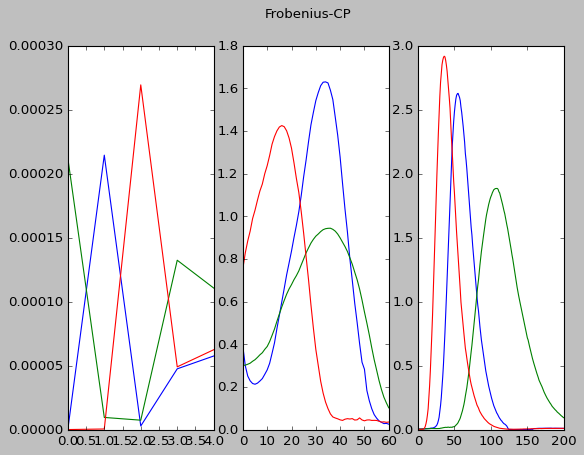

In [15]:
factor_cp = tl.decomposition.non_negative_parafac(X, rank = 3, init = "random", n_iter_max = 5000)
X_cp = tl.cp_tensor.cp_to_tensor(factor_cp)

plt.subplot(1, 3, 1)
plt.plot(range(X_cp.shape[0]),factor_cp.factors[0]);

plt.subplot(1, 3, 2)
plt.plot(range(X_cp.shape[1]),factor_cp.factors[1]);

plt.subplot(1, 3, 3)
plt.plot(range(X_cp.shape[2]),factor_cp.factors[2]);

plt.suptitle("Frobenius-CP")

Text(0.5, 0.98, 'WTF')

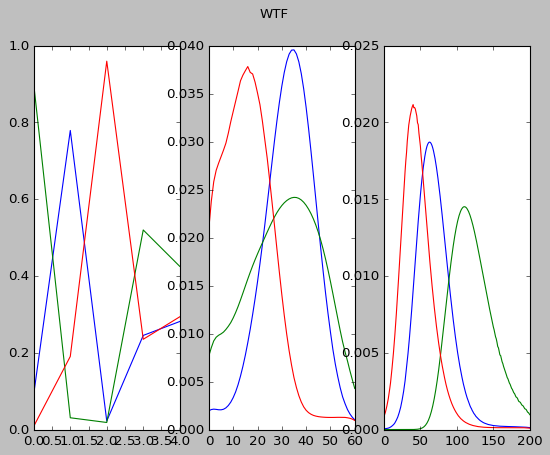

In [16]:
plt.subplot(1, 3, 1)
plt.plot(range(X_cp.shape[0]), A[0].cpu());

plt.subplot(1, 3, 2)
plt.plot(range(X_cp.shape[1]), A[1].cpu());

plt.subplot(1, 3, 3)
plt.plot(range(X_cp.shape[2]), A[2].cpu());

plt.suptitle("WTF")

In [17]:
X_hat = tl.tenalg.multi_mode_dot(S, A).cpu()


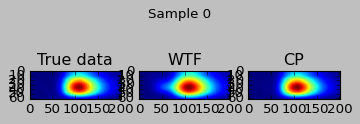

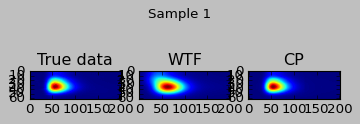

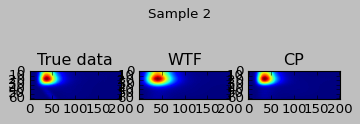

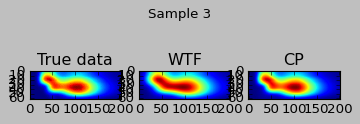

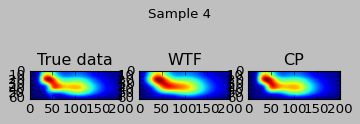

In [18]:
for i in range(5):
    plt.figure(figsize = (5, 2))
    plt.subplot(1, 3, 1)
    plt.imshow(X[i, :, :])
    plt.title("True data")
    plt.subplot(1, 3, 2)
    plt.imshow(X_hat[i, :, :])
    plt.title("WTF")
    plt.subplot(1, 3, 3)
    plt.imshow(X_cp[i, :, :])
    plt.title("CP")
    plt.suptitle(f"Sample {i}")
